# Naive Bayes
##### Sean Wade

In [11]:
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from pymongo import MongoClient
import pickle
import pandas as pd
from yelp_utils import preprocess_reviews, data_manager

from matplotlib import pyplot as plt
import seaborn as sns
% matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.css').read())

In [2]:
pos_list, neg_list = preprocess_reviews.prepare_classify(100)
model = NaiveBayesClassifier(pos_list + neg_list )

In [3]:
client = MongoClient()
db = client.yelp

In [4]:
review = data_manager.radom_review(1)[0]
test_text = review['text']
classification = model.classify(test_text)
print "Rating: %s" % review['stars']
print "Class: %s" % classification
print '-'*45
print test_text

NameError: name 'model' is not defined

## How to add to model

In [40]:
pickle.dump(model, open('m.p','wb'))

In [5]:
load_model = pickle.load(open('m.p', 'rb'))

In [5]:
pos_list, neg_list = preprocess_reviews.prepare_classify(200)
load_model.update(pos_list + neg_list)

KeyboardInterrupt: 

In [105]:
test_pos_list, test_neg_list = preprocess_reviews.prepare_classify(100)
test = test_pos_list + test_pos_list
model.accuracy(test)

KeyboardInterrupt: 

In [8]:
load_model.show_informative_features()

Most Informative Features
         contains(asked) = True              neg : pos    =     16.3 : 1.0
          contains(rude) = True              neg : pos    =     11.0 : 1.0
         contains(worst) = True              neg : pos    =      9.7 : 1.0
       contains(another) = True              neg : pos    =      9.7 : 1.0
          contains(even) = True              neg : pos    =      7.0 : 1.0
         contains(point) = True              neg : pos    =      7.0 : 1.0
          contains(long) = True              neg : pos    =      7.0 : 1.0
        contains(should) = True              neg : pos    =      6.6 : 1.0
         contains(whole) = True              neg : pos    =      6.3 : 1.0
           contains(big) = True              pos : neg    =      6.3 : 1.0


## Other

In [13]:
from sumy.nlp import tokenizers
from sumy.parsers import plaintext
from sumy.summarizers import lex_rank

In [55]:
business_id = data_manager.random_business()[0]['business_id']
review_list = data_manager.get_business_reviews(business_id)

[{u'_id': ObjectId('58b4f54cf4a3170ac3ab6d21'),
  u'business_id': u'kS5aJfwWWY_m1rqnJC4Gyg',
  u'date': u'2013-01-15',
  u'review_id': u'Z0jxuWVva_hF-bDk_DrNyQ',
  u'stars': 5,
  u'text': u'Amazing church, I love Sunday mornings.  Everyone is very friendly, and the pastors are very hard workers.  The service is modern and passionate.  The music is always upbeat and positive!  The location is incorrect check their website.  The new building is awesome!',
  u'type': u'review',
  u'user_id': u'VQoFVt5I5hkUtCZk5t_ZaA',
  u'votes': {u'cool': 0, u'funny': 0, u'useful': 1}},
 {u'_id': ObjectId('58b4f54cf4a3170ac3ab6d22'),
  u'business_id': u'kS5aJfwWWY_m1rqnJC4Gyg',
  u'date': u'2013-03-11',
  u'review_id': u'5g280n1NmfNxybDfySm1Lg',
  u'stars': 2,
  u'text': u'My wife has been going to the yoga studio across the street from this church and asked if I wouldn\'t mind checking it out one weekend. I took a look at the website and read about it and it seemed like it may be a cool young hip church

In [57]:
all_reviews = ' '.join([x['text'] for x in review_list])

In [58]:
all_reviews

u'Amazing church, I love Sunday mornings.  Everyone is very friendly, and the pastors are very hard workers.  The service is modern and passionate.  The music is always upbeat and positive!  The location is incorrect check their website.  The new building is awesome! My wife has been going to the yoga studio across the street from this church and asked if I wouldn\'t mind checking it out one weekend. I took a look at the website and read about it and it seemed like it may be a cool young hip church to check out since it comes off as very contemporary place... \n\nAs much excitement as I had to check it out once we got there I became a little unsure. We checked in our kids to the children\'s area which definitely seemed well put together and organized. So it was off to a good start. The folks that we first met seemed nice but almost a little too excited that we had come to check out the church, but that is normal in a sense in the church world. \n\nWaking into the building I was definit

In [60]:
tokenizer = tokenizers.Tokenizer('english')    
parse = plaintext.PlaintextParser(all_reviews, tokenizer)
doc = parse.document  
rank = lex_rank.LexRankSummarizer

#Print the top ten results of the sorting
print('\nThe ranked data is as follows:')
print('\n------------------------------')

i = 0
for s in rank(doc, ):
    i+=1
    print('{}: {}'.format(i, s))
    print('\n')


The ranked data is as follows:

------------------------------


ValueError: Stemmer has to be a callable object

## Time Series

In [182]:
cursor = db.reviews.find({'business_id': 'sbW8qHJgzEIH42B0S-3New'}).sort('date',1)
stars = [x['stars'] for x in cursor]
cursor.rewind()
dates = [x['date'] for x in cursor]
ratings = pd.Series(stars, index=dates)
ratings.index = pd.to_datetime(ratings.index, format='%Y-%m-%d')

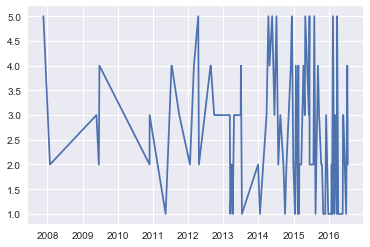

In [190]:
plt.plot(ratings)

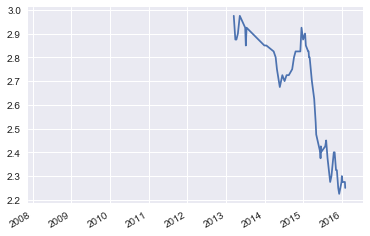

In [191]:
ratings.rolling(window=40, center=True).mean().plot()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


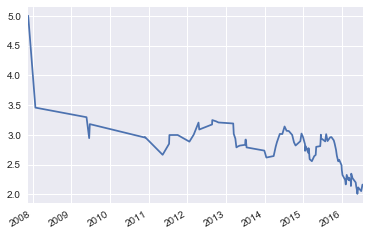

In [199]:
pd.ewma(ratings,  halflife=12).plot()

In [254]:
np.array([stars, polarity, subjectivity]).shape

(3, 0)

In [328]:
business_id = data_manager.random_business()[0]['business_id']
print business_id
print len(data_manager.get_business_reviews(business_id))
cursor = db.reviews.find({'business_id': business_id}).sort('date',1)
dates = [x['date'] for x in cursor]
cursor.rewind()
subjectivity = [TextBlob(x['text']).sentiment.subjectivity for x in cursor]
cursor.rewind()
polarity = [TextBlob(x['text']).sentiment.polarity for x in cursor]
cursor.rewind()
stars = [x['stars'] for x in cursor]
df = pd.DataFrame(np.array([stars, polarity, subjectivity]).T, index=dates)
df.index = pd.to_datetime(dates, format='%Y-%m-%d')

yRhDoKG2calmtU_7MAt90g
0


In [329]:
df

,0,1,2


In [330]:
w = 2
df[0].rolling(window=w, center=False).mean().plot()
df[1].rolling(window=w, center=False).mean().plot()
df[2].rolling(window=w, center=False).mean().plot()
plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot